Followed this tutorial 

https://www.youtube.com/watch?v=2xrzJibPl3c

In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tqdm import tqdm
import random
import cv2

In [2]:
%cd ..
from google.colab import drive
drive.mount('./content/gdrive')

/
Mounted at ./content/gdrive


In [3]:
DATADIR = "/content/gdrive/MyDrive/Gait_analysis/all_fixed/data_150"

In [4]:
CATEGORIES = ["normal_resized150", "abnormal_resized150"]

In [5]:
# To make the training data and labels from the datadir and categories
c = 3
IMG_SIZE = 64
training_data = []
labels = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            #try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append(new_array)
            
            if "abnormal_resized150" in category:
                labels.append(0)
            else:
                labels.append(1)
           # except Exception as e:
            #    pass

create_training_data()

In [6]:
type(training_data)

list

In [7]:
training_data = np.array(training_data)
labels = np.array(labels)

In [8]:
type(training_data)

numpy.ndarray

In [9]:
training_data.shape

(276, 64, 64)

In [10]:
training_data_flattened = training_data.reshape(len(training_data), 64, 64, 1)
training_data_flattened.shape

(276, 64, 64, 1)

In [11]:
training_data_reshaped = np.broadcast_to(training_data_flattened, (276, 64, 64, 3))
training_data_reshaped.shape

(276, 64, 64, 3)

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_data_reshaped, labels, random_state = 0)

In [65]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(207, 64, 64, 3)
(207,)
(69, 64, 64, 3)
(69,)


In [66]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)
print(train_labels.shape)
print(test_labels.shape)

(207, 2)
(69, 2)


In [67]:
# Final Split to be fed into the model

print(X_train.shape)
print(train_labels.shape)
print(X_test.shape)
print(test_labels.shape)

(207, 64, 64, 3)
(207, 2)
(69, 64, 64, 3)
(69, 2)


VGG16

In [84]:
from tensorflow.keras.applications import VGG16

model = VGG16(weights = "imagenet", include_top = False, input_shape = (64, 64, 3))

In [69]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [85]:
X_test_VGG_output = model.predict(X_test, verbose = 1)
X_train_VGG_output = model.predict(X_train, verbose = 1) #Use this as feature extractor

7/7 [==============================] - 9s 1s/step


In [86]:
print(X_test_VGG_output.shape)
print(X_train_VGG_output.shape)

(69, 2, 2, 512)
(207, 2, 2, 512)


In [87]:
import numpy as np
X_test_new = np.reshape(X_test_VGG_output, (69, 2*2*512))
X_train_new = np.reshape(X_train_VGG_output, (207, 2*2*512))

In [88]:
print(X_test_new.shape)
print(X_train_new.shape)

(69, 2048)
(207, 2048)


In [89]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

new_model = models.Sequential()
new_model.add(layers.Dense(256, activation = "relu", input_dim = 2*2*512))
new_model.add(layers.Dropout(0.5))
new_model.add(layers.Dense(2, activation = "sigmoid"))

new_model.compile(optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"])
history = new_model.fit(X_train_new, train_labels, epochs = 8, batch_size = 10, validation_data = (X_test_new, test_labels))

Epoch 1/8
21/21 [==============================] - 1s 15ms/step - loss: 5.8413 - accuracy: 0.7778 - val_loss: 0.6671 - val_accuracy: 0.9130
Epoch 2/8
21/21 [==============================] - 0s 8ms/step - loss: 1.6331 - accuracy: 0.9082 - val_loss: 2.8188 - val_accuracy: 0.8116
Epoch 3/8
21/21 [==============================] - 0s 9ms/step - loss: 1.1412 - accuracy: 0.9275 - val_loss: 0.2078 - val_accuracy: 0.9855
Epoch 4/8
21/21 [==============================] - 0s 10ms/step - loss: 0.3930 - accuracy: 0.9469 - val_loss: 0.0186 - val_accuracy: 1.0000
Epoch 5/8
21/21 [==============================] - 0s 9ms/step - loss: 0.6058 - accuracy: 0.9614 - val_loss: 1.3728e-04 - val_accuracy: 1.0000
Epoch 6/8
21/21 [==============================] - 0s 9ms/step - loss: 0.2004 - accuracy: 0.9662 - val_loss: 0.1195 - val_accuracy: 0.9710
Epoch 7/8
21/21 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9952 - val_loss: 1.0067e-04 - val_accuracy: 1.0000
Epoch 8/8
21/21 [

Visualization

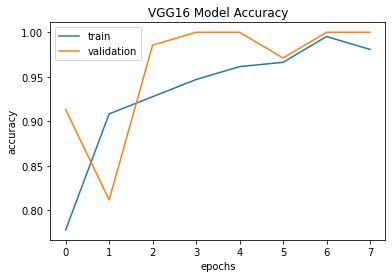

In [90]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("VGG16 Model Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

In [91]:
predictions = new_model.predict(X_test_new)
y_pred = np.argmax(predictions, axis=1)

test_loss, test_acc = new_model.evaluate(X_test_new , test_labels)
print('Test loss', test_loss)
print('Test accuracy', test_acc)

3/3 [==============================] - 0s 6ms/step - loss: 2.4871e-05 - accuracy: 1.0000
Test loss 2.4870534616638906e-05
Test accuracy 1.0


In [82]:
y_pred[1:5]

array([1, 1, 1, 0])

In [83]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        33

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



In [54]:
y_true = y_test

In [92]:
# Let's view the confusion matrix
import sklearn
from sklearn.metrics import confusion_matrix

cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
cm

array([[36,  0],
       [ 0, 33]])

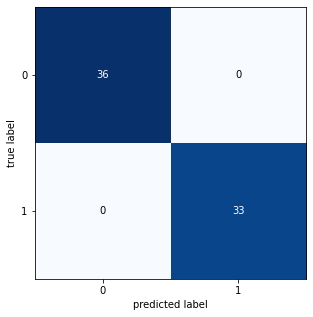

In [93]:
import matplotlib.pyplot as plt

CM = confusion_matrix(y_true,y_pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM, figsize=(5,5))
plt.show()

In [28]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, pos_label=0)

0.9722222222222222

In [29]:
sensitivity = sklearn.metrics.recall_score(y_true , y_pred)
sensitivity

1.0

In [30]:
specificity = sklearn.metrics.recall_score(np.logical_not(y_true) , np.logical_not(y_pred))
specificity

0.9722222222222222

In [31]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
precision = tp / (tp+fp)
recall = tp / (tp+fn)

In [32]:
print(specificity)
print(sensitivity)
print(precision)
print(recall)

0.9722222222222222
1.0
0.9705882352941176
1.0


NEEDs SOME brain storming

In [ ]:
# predict with the trained model 

labels = ["abnormal gait","normal gait"]
sample_image = X_test_new[32]
sample_label = test_labels[32]
predicted_label = y_pred[32]
model.predict([sample_image])
print("The true label says it is a", labels[predicted_label])
print("The model predicted it to be a", labels[sample_label])


# To see the predicted image, we need to change the 1D array to 2D array

example = np.reshape(sample_image, (64, 64))
plt.imshow(example, cmap = "gray")
plt.xlabel(labels[sample_label])
plt.show()

ValueError: ignored

In [ ]:
from keras.preprocessing import image
Img = image.load_img("", target_size = (64, 64))
Img = np.asarray(Img)
plt.imshow(Img)
Img = np.expand_dims(Img, axis=0)